#Two class classification of Paediatric heart sound signals using the continuous wavelet transform features.

Anurag Patel (121CS0201)

Spandan Kumar Panda (121CS0199)

Anubhuti Pandey (121CS0200)

Palak Deb Patra (121CS0202)


In [1]:
import os
import cv2
import numpy as np
import librosa
import random
import pywt
from skimage.measure import block_reduce
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,AveragePooling2D
from tensorflow.keras import layers, optimizers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
audio_data, sampling_rate = librosa.load("./abnormal/ZCH0534.wav", sr=None, mono=True)

print(f"The sampling rate of each sample: {sampling_rate} Hz")

The sampling rate of each sample: 8000 Hz


In [6]:
# Function to load audio data from file
# downsampling at 1000 Hz
def load_audio(file_path):
    audio_data, _ = librosa.load(file_path, sr=1000, mono=True)  # Load mono audio
    return audio_data

In [4]:
#function for plotting Amplitude vs time

def plot_audio_waveform(audio_data, sample_rate):
    # Calculate the duration of the audio signal
    duration = len(audio_data) / sample_rate

    # Create a time array for plotting
    time = np.linspace(0, duration, len(audio_data))

    # Plot the amplitude versus time
    plt.figure(figsize=(10, 4))
    plt.plot(time, audio_data, color='b')
    plt.title('Amplitude vs Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

NORMAL


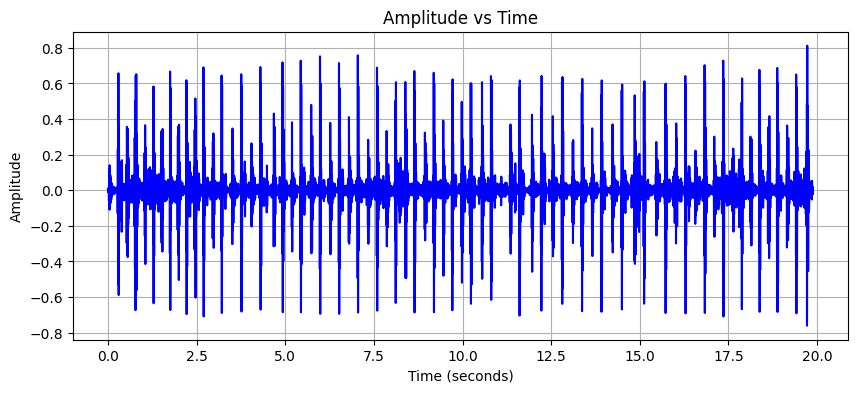

ABNORMAL


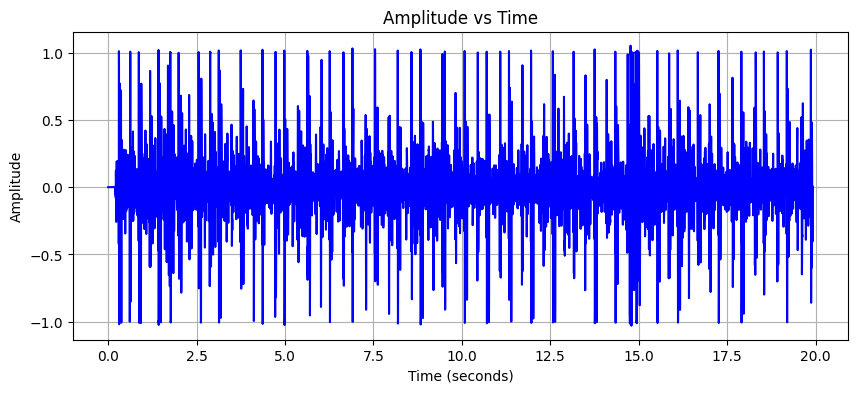

In [8]:
normal_path = './normal/ZCH0009.wav'
abnormal_path = "./abnormal/ZCH0534.wav"

load_normal = load_audio(normal_path)
load_abnormal = load_audio(abnormal_path)
print("NORMAL")
plot_audio_waveform(load_normal,1000)
print("ABNORMAL")
plot_audio_waveform(load_abnormal,1000)

In [9]:
# Standardizing the input dimensions
fixed_length = 20000

# Function to pad or truncate audio data arrays to the fixed length
def preprocess_audio(audio_data):
    if len(audio_data) < fixed_length:
        # If the array is shorter than the fixed length, pad it with zeros
        padded_audio_data = np.pad(audio_data, (0, fixed_length - len(audio_data)), 'constant')
        return padded_audio_data
    elif len(audio_data) > fixed_length:
        # If the array is longer than the fixed length, truncate it
        truncated_audio_data = audio_data[:fixed_length]
        return truncated_audio_data
    else:
        # If the array is already of the fixed length, return it unchanged
        return audio_data

In [10]:
# Directory paths for normal and abnormal heartbeats
normal_dir = './normal'
abnormal_dir = './abnormal'

# Create a list to store dataset entries (audio data and labels)
dataset = []

#new sample rate
new_sample_rate = 1000
sample_rate = 8000
more =0;
less =0;

# Assign labels for normal heartbeats (label = 0)
for filename in os.listdir(normal_dir):
    file_path = os.path.join(normal_dir, filename)
    audio_data = load_audio(file_path)# Load audio data
    audio_data = preprocess_audio(audio_data) # standardizing the input data
    dataset.append((audio_data, 0))  # Append (audio data, label) tuple to dataset

# Assign labels for abnormal heartbeats (label = 1)
for filename in os.listdir(abnormal_dir):
    file_path = os.path.join(abnormal_dir, filename)
    audio_data = load_audio(file_path)  # Load audio data
    audio_data = preprocess_audio(audio_data) # standardizing the input data
    dataset.append((audio_data, 1))  # Append (audio data, label) tuple to dataset

# Shuffle the dataset
random.shuffle(dataset)

# Now, the dataset contains audio data along with their corresponding labels

In [11]:
def segment_dataset(dataset):
    segmented_dataset = []

    for audio_data, label in dataset:
        # Determine segment size
        segment_size = len(audio_data) // 4

        # Divide the audio data into segments
        segmented_arrays = [audio_data[i*segment_size:(i+1)*segment_size] for i in range(4)]

        # Append each segment along with its label to the segmented dataset
        for segment in segmented_arrays:
            segmented_dataset.append((segment, label))

    return segmented_dataset

dataset = segment_dataset(dataset)

In [12]:
print(f"The size of dataset we have: {len(dataset)}")

The size of dataset we have: 3764


In [13]:
def extract_cwt_features(audio_data, scales=np.arange(1, 128)):
    # Perform Continuous Wavelet Transform (CWT) using pywt
    cwt_data, _ = pywt.cwt(audio_data, scales, 'morl')

    # Take absolute values of CWT coefficients as features
    cwt_features = np.abs(cwt_data)

    return cwt_features

temp = extract_cwt_features(dataset[0][0])
temp.shape

(127, 5000)

In [14]:
def plot_cwt_scalogram(audio_data, sampling_rate, scales=np.arange(1,128)):
    # scaler = StandardScaler()
    # Calculate the CWT coefficients
    coeffs, _ = pywt.cwt(audio_data, scales, 'morl')
    # coeffs = scaler.fit_transform(coeffs)
    print(f"The shape of cwt extract: {coeffs.shape}")

    # Calculate time axis
    time = np.arange(0, len(audio_data)) / sampling_rate

    # Plot scalogram
    plt.figure(figsize=(10, 4))
    plt.imshow(np.abs(coeffs), extent=[0, len(audio_data), scales[-1], scales[0]],
               aspect='auto', cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.xlabel('Time (s)')
    plt.ylabel('Scale')
    plt.title('Scalogram of Continuous Wavelet Transform')
    plt.show()


NORMAL
The shape of cwt extract: (127, 19880)


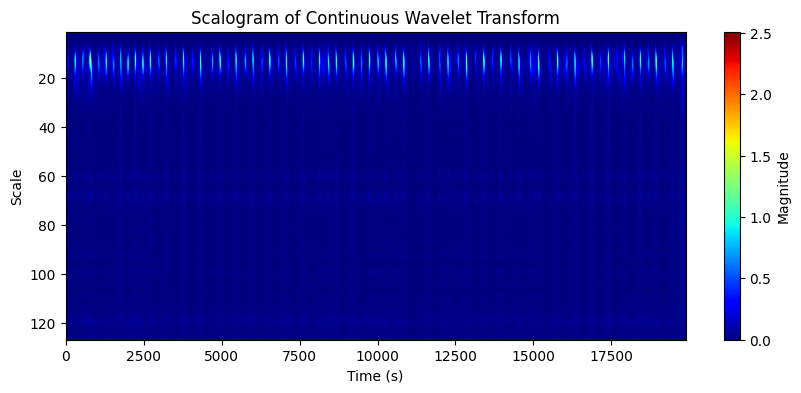

ABNORMAL
The shape of cwt extract: (127, 19920)


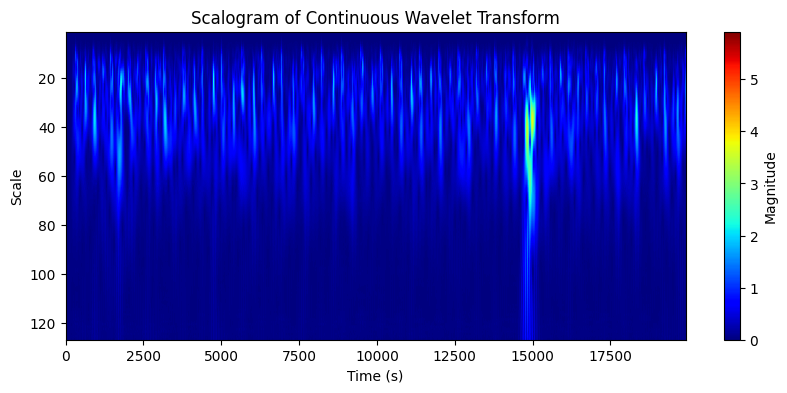

In [15]:
print("NORMAL")
plot_cwt_scalogram(load_normal,1000)
print("ABNORMAL")
plot_cwt_scalogram(load_abnormal,1000)

In [16]:
#spillting the dataset

# Split the dataset into features (audio data) and labels
X = [entry[0] for entry in dataset]  # Features (audio data)
y = [entry[1] for entry in dataset]  # Labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
def extract_cwt_features_from_audio_dataset(audio_dataset, sample_rate, scales=np.arange(1, 128)):
  cwt_features_dataset = []

  for audio_data in audio_dataset:
      # Compute CWT features for each audio sample
      cwt_data, _ = pywt.cwt(audio_data, scales, 'morl')

      # Take absolute values of CWT coefficients as features
      cwt_features = np.abs(cwt_data)

      pca = PCA(n_components=100) # Assuming you want to reduce to 100 dimensions

      # Fit and transform the data matrix using PCA
      reduced_data = pca.fit_transform(cwt_features)

      # Append CWT features to the dataset
      cwt_features_dataset.append(reduced_data)

  return cwt_features_dataset

In [18]:
X_train_extracted = extract_cwt_features_from_audio_dataset(X_train,1000)
X_test_extracted = extract_cwt_features_from_audio_dataset(X_test,1000)

In [19]:
Xtrain = np.array(X_train_extracted)
Xtest = np.array(X_test_extracted)
ytrain = np.array(y_train)
ytest = np.array(y_test)

Xtrain.shape , ytrain.shape, Xtest.shape, ytest.shape

((3011, 127, 100), (3011,), (753, 127, 100), (753,))

In [66]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plotting the confusion matrix with default labels '0' and '1'
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

#MODEL 1

In [20]:
model1 = Sequential()

# Add convolutional layers and pooling layers
model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(127, 100, 1)))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model1.add(Conv2D(8, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dropout(0.5))

# Add dense layers
model1.add(Dense(8, activation='relu'))
model1.add(Dense(2, activation='softmax'))

adam = Adam(learning_rate=0.01)
# Compile the model with sparse_categorical_crossentropy
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 98, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 49, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 62, 49, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 47, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 23, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 23, 32)        0

In [ ]:
model1_accuracies = []
for i in range(3):
     print("step: ",i+1)
     model1.fit(Xtrain, ytrain, epochs=15, batch_size=32)
     test_loss_m1, test_accuracy_m1 = model1.evaluate(Xtest, ytest, verbose=2)
     model1_accuracies.append(test_accuracy_m1)

mean_test_accuracy_m1 = np.mean(model1_accuracies)
print("Mean test accuracy Model 1:", mean_test_accuracy_m1)

step:  1
Epoch 1/15
95/95 [==============================] - 96s 1s/step - loss: 0.5336 - accuracy: 0.7373
Epoch 2/15
95/95 [==============================] - 99s 1s/step - loss: 0.5330 - accuracy: 0.7350
Epoch 3/15
95/95 [==============================] - 99s 1s/step - loss: 0.5338 - accuracy: 0.7277
Epoch 4/15
95/95 [==============================] - 97s 1s/step - loss: 0.5302 - accuracy: 0.7297
Epoch 5/15
95/95 [==============================] - 95s 1s/step - loss: 0.5203 - accuracy: 0.7419
Epoch 6/15
95/95 [==============================] - 97s 1s/step - loss: 0.5276 - accuracy: 0.7400
Epoch 7/15
95/95 [==============================] - 96s 1s/step - loss: 0.5215 - accuracy: 0.7406
Epoch 8/15
95/95 [==============================] - 97s 1s/step - loss: 0.5151 - accuracy: 0.7449
Epoch 9/15
95/95 [==============================] - 97s 1s/step - loss: 0.5205 - accuracy: 0.7496
Epoch 10/15
95/95 [==============================] - 96s 1s/step - loss: 0.5201 - accuracy: 0.7413
Epoch 11/1

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Assuming you have training and validation data (X_train, y_train, X_val, y_val)
history = model1.fit(Xtrain, ytrain, epochs=20, batch_size=32, validation_data=(Xtest, ytest), callbacks=[early_stopping, checkpoint])

# After training, load the best model weights
model1.load_weights('best_model_weights.h5')

# Evaluate the model
loss, accuracy = model1.evaluate(Xtest, ytest)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/20
95/95 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.5686
Epoch 1: val_accuracy improved from -inf to 0.57105, saving model to best_model_weights.h5
95/95 [==============================] - 107s 1s/step - loss: 0.6917 - accuracy: 0.5686 - val_loss: 0.6757 - val_accuracy: 0.5710
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.5789
Epoch 2: val_accuracy improved from 0.57105 to 0.58566, saving model to best_model_weights.h5
95/95 [==============================] - 107s 1s/step - loss: 0.6791 - accuracy: 0.5789 - val_loss: 0.6698 - val_accuracy: 0.5857
Epoch 3/20
95/95 [==============================] - ETA: 0s - loss: 0.6672 - accuracy: 0.5991
Epoch 3: val_accuracy improved from 0.58566 to 0.60292, saving model to best_model_weights.h5
95/95 [==============================] - 100s 1s/step - loss: 0.6672 - accuracy: 0.5991 - val_loss: 0.6593 - val_accuracy: 0.6029
Epoch 4/20
95/95 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.5998
Epoch 4: val_accuracy improved from 0.60292 to 0.61089, saving model to best_model_weights.h5
95/95 [==============================] - 113s 1s/step - loss: 0.6641 - accuracy: 0.5998 - val_loss: 0.6615 - val_accuracy: 0.6109
Epoch 5/20
95/95 [==============================] - ETA: 

In [21]:
model1.load_weights('best_model_weights.h5')

In [22]:
# Evaluate the model on the test data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
y_pred = model1.predict(Xtest)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Calculate evaluation metrics
accuracy = accuracy_score(ytest, y_pred_classes)
precision = precision_score(ytest, y_pred_classes, average='weighted')
recall = recall_score(ytest, y_pred_classes, average='weighted')
f1 = f1_score(ytest, y_pred_classes, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")



24/24 [==============================] - 6s 251ms/step
Accuracy: 0.7822045152722443
Precision: 0.7847598266536012
Recall: 0.7822045152722443
F1-score: 0.7782100002462251


In [23]:
from sklearn.metrics import confusion_matrix

def calculate_sensitivity_specificity(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Extract TP, TN, FP, FN from confusion matrix
    TP = cm[1, 1]  # True Positives
    TN = cm[0, 0]  # True Negatives
    FP = cm[0, 1]  # False Positives
    FN = cm[1, 0]  # False Negatives

    # Calculate Sensitivity (True Positive Rate, TPR)
    sensitivity = TP / (TP + FN)

    # Calculate Specificity (True Negative Rate, TNR)
    specificity = TN / (TN + FP)

    return sensitivity, specificity

# Assuming y_true contains the true binary labels (0 and 1) and y_pred contains the predicted labels
sensitivity, specificity = calculate_sensitivity_specificity(ytest, y_pred_classes)

print(f"Sensitivity (True Positive Rate, TPR): {sensitivity}")
print(f"Specificity (True Negative Rate, TNR): {specificity}")


Sensitivity (True Positive Rate, TPR): 0.654320987654321
Specificity (True Negative Rate, TNR): 0.8787878787878788


|True \ Predicted|    0     |    1     |
----------------------------------------
|    0     |   377    |    52    |
|    1     |   112    |   212    |
----------------------------------------


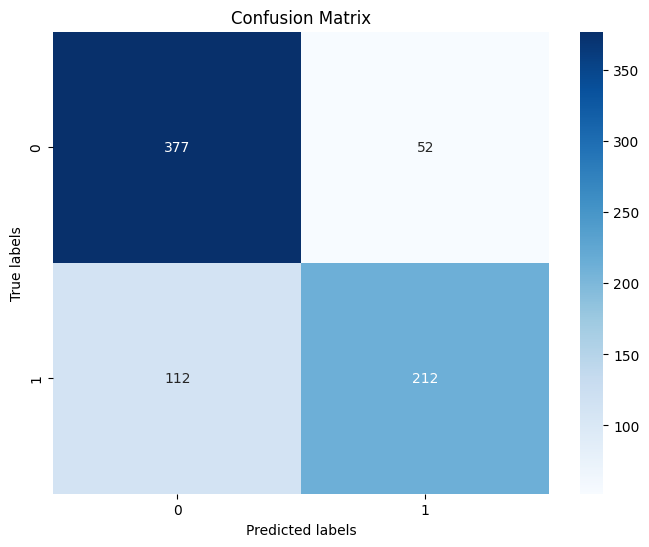

In [67]:
from sklearn.metrics import confusion_matrix

def display_confusion_matrix(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    if labels is None:
        labels = sorted(set(y_true).union(y_pred))

    header = "|{:^10}|".format("True \\ Predicted")
    header += "|".join(["{:^10}".format(label) for label in labels]) + "|"
    print(header)

    print("-" * len(header))

    for i, row_label in enumerate(labels):
        row = "|{:^10}|".format(row_label)
        row += "|".join(["{:^10}".format(cm[i, j]) for j in range(len(labels))]) + "|"
        print(row)

    print("-" * len(header))

# Example usage:
# Assuming y_true contains the true labels and y_pred contains the predicted labels
# Pass your true and predicted labels to the function
display_confusion_matrix(ytest, y_pred_classes)
plot_confusion_matrix(ytest,y_pred_classes)


#MODEL 2

In [25]:
X_train_flattened = np.array([feature.flatten() for feature in X_train_extracted])
X_test_flattened = np.array([feature.flatten() for feature in X_test_extracted])
X_train_flattened.shape,X_test_flattened.shape

((3011, 12700), (753, 12700))

In [26]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
random_forest.fit(X_train_flattened, ytrain)

# Make predictions on the test set
y_pred_1 = random_forest.predict(X_test_flattened)

# Calculate accuracy
accuracy = accuracy_score(ytest, y_pred_1)
precision = precision_score(ytest, y_pred_1, average='weighted')
recall = recall_score(ytest, y_pred_1, average='weighted')
f1 = f1_score(ytest, y_pred_1, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.7450199203187251
Precision: 0.7509162771919894
Recall: 0.7450199203187251
F1-score: 0.7368453097907374


In [27]:
display_confusion_matrix(ytest, y_pred_1)

|True \ Predicted|    0     |    1     |
----------------------------------------
|    0     |   377    |    52    |
|    1     |   140    |   184    |
----------------------------------------


In [28]:
# Assuming y_true contains the true binary labels (0 and 1) and y_pred contains the predicted labels
sensitivity_1, specificity_1 = calculate_sensitivity_specificity(ytest, y_pred_1)

print(f"Sensitivity (True Positive Rate, TPR): {sensitivity_1}")
print(f"Specificity (True Negative Rate, TNR): {specificity_1}")

Sensitivity (True Positive Rate, TPR): 0.5679012345679012
Specificity (True Negative Rate, TNR): 0.8787878787878788


#MODEL 3

In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Example: Suppose you have a list of CWT features stored in 'cwt_features'
# Assuming 'cwt_features' is a list of numpy arrays with shape (127, 100, 1)


# Load pre-trained ResNet50 model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(127, 100, 3))

# Freeze ResNet layers so they won't be trained
for layer in resnet_base.layers:
    layer.trainable = False

# Add custom layers for classification on top of ResNet50
x = Flatten()(resnet_base.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # 'num_classes' is the number of output classes

# Create the model
model_4 = Model(inputs=resnet_base.input, outputs=predictions)

# Compile the model
model_4.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Now you can train or evaluate the model using your data



In [ ]:
X_train_reduced_np = np.array(X_train_extracted)
X_test_reduced_np = np.array(X_test_extracted)

# Reshape the PCA-reduced features to match ResNet input shape (127x127x1)
X_train_reshaped = X_train_reduced_np.reshape(X_train_reduced_np.shape[0], 127, 100, 1)
X_test_reshaped = X_test_reduced_np.reshape(X_test_reduced_np.shape[0], 127, 100, 1)

# Replicate the single channel to create a pseudo-RGB image
X_train_rgb = np.concatenate([X_train_reshaped, X_train_reshaped, X_train_reshaped], axis=-1)
X_test_rgb = np.concatenate([X_test_reshaped, X_test_reshaped, X_test_reshaped], axis=-1)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have X_train, y_train, X_test, y_test after data preprocessing and splitting

# Train your modified ResNet-50 V2 model
history = model_4.fit(X_train_rgb, ytrain, epochs=13, batch_size=32,validation_data=(X_test_rgb, ytest))

Epoch 1/13
95/95 [==============================] - 274s 3s/step - loss: 1.5621 - accuracy: 0.5706 - val_loss: 0.6162 - val_accuracy: 0.6773
Epoch 2/13
95/95 [==============================] - 262s 3s/step - loss: 0.7116 - accuracy: 0.6377 - val_loss: 0.6130 - val_accuracy: 0.6866
Epoch 3/13
95/95 [==============================] - 220s 2s/step - loss: 0.7208 - accuracy: 0.6436 - val_loss: 0.6373 - val_accuracy: 0.6892
Epoch 4/13
95/95 [==============================] - 218s 2s/step - loss: 0.5753 - accuracy: 0.6928 - val_loss: 0.6539 - val_accuracy: 0.6016
Epoch 5/13
95/95 [==============================] - 222s 2s/step - loss: 0.5835 - accuracy: 0.6868 - val_loss: 0.9338 - val_accuracy: 0.5193
Epoch 6/13
95/95 [==============================] - 219s 2s/step - loss: 0.5652 - accuracy: 0.7041 - val_loss: 0.5777 - val_accuracy: 0.7105
Epoch 7/13
95/95 [==============================] - 219s 2s/step - loss: 0.5425 - accuracy: 0.7107 - val_loss: 0.6142 - val_accuracy: 0.6388
Epoch 8/13
95

In [ ]:
y_pred_2 = model_4.predict(X_test_rgb)
y_pred_classes_2 = np.argmax(y_pred_2, axis=1)  # Convert probabilities to class labels

# Calculate evaluation metrics
accuracy = accuracy_score(ytest, y_pred_classes_2)
precision = precision_score(ytest, y_pred_classes_2, average='weighted')
recall = recall_score(ytest, y_pred_classes_2, average='weighted')
f1 = f1_score(ytest, y_pred_classes_2, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

24/24 [==============================] - 41s 2s/step
Accuracy: 0.7091633466135459
Precision: 0.7438976645066857
Recall: 0.7091633466135459
F1-score: 0.6821106715832931


In [ ]:
display_confusion_matrix(ytest, y_pred_classes_2)

|True \ Predicted|    0     |    1     |
----------------------------------------
|    0     |   404    |    26    |
|    1     |   193    |   130    |
----------------------------------------


In [ ]:
# Assuming y_true contains the true binary labels (0 and 1) and y_pred contains the predicted labels
sensitivity_2, specificity_2 = calculate_sensitivity_specificity(ytest, y_pred_classes_2)

print(f"Sensitivity (True Positive Rate, TPR): {sensitivity_2}")
print(f"Specificity (True Negative Rate, TNR): {specificity_2}")

Sensitivity (True Positive Rate, TPR): 0.4024767801857585
Specificity (True Negative Rate, TNR): 0.9395348837209302


#MODEL 4

In [45]:
learning_rate = 0.001
build_model_4 = tf.keras.Sequential([
     layers.Conv2D(16, (3, 3), strides=(2, 2), activation='relu', input_shape=(127,100,1)),
     layers.AvgPool2D((2, 2), strides=(2, 2)),
     layers.Conv2D(32, (3, 3), strides=(2, 2), activation='relu'),
     layers.AvgPool2D((2, 2), strides=(2, 2)),
     layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu'),
     layers.AvgPool2D((2, 2), strides=(2, 2)),
     layers.Flatten(),
     layers.Dense(8, activation='relu'),
     layers.Dense(2, activation='softmax')
])
optimizer = optimizers.Adam(learning_rate=learning_rate)
build_model_4.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
build_model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 63, 49, 16)        160       
                                                                 
 average_pooling2d_9 (Avera  (None, 31, 24, 16)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_14 (Conv2D)          (None, 15, 11, 32)        4640      
                                                                 
 average_pooling2d_10 (Aver  (None, 7, 5, 32)          0         
 agePooling2D)                                                   
                                                                 
 conv2d_15 (Conv2D)          (None, 3, 2, 64)          18496     
                                                                 
 average_pooling2d_11 (Aver  (None, 1, 1, 64)         

In [48]:
from keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('best_model_weights_2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Assuming you have training and validation data (X_train, y_train, X_val, y_val)
history = build_model_4.fit(Xtrain, ytrain, epochs=75, batch_size=32, validation_data=(Xtest, ytest), callbacks=[checkpoint])

# After training, load the best model weights
build_model_4.load_weights('best_model_weights_2.h5')

# Evaluate the model
loss, accuracy = build_model_4.evaluate(Xtest, ytest)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/75
94/95 [============================>.] - ETA: 0s - loss: 0.5055 - accuracy: 0.7503
Epoch 1: val_accuracy improved from -inf to 0.71315, saving model to best_model_weights_2.h5
95/95 [==============================] - 9s 100ms/step - loss: 0.5056 - accuracy: 0.7502 - val_loss: 0.5560 - val_accuracy: 0.7131
Epoch 2/75
 1/95 [..............................] - ETA: 5s - loss: 0.6339 - accuracy: 0.7188

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


93/95 [============================>.] - ETA: 0s - loss: 0.5075 - accuracy: 0.7463
Epoch 2: val_accuracy improved from 0.71315 to 0.73572, saving model to best_model_weights_2.h5
95/95 [==============================] - 6s 67ms/step - loss: 0.5071 - accuracy: 0.7459 - val_loss: 0.5342 - val_accuracy: 0.7357
Epoch 3/75
94/95 [============================>.] - ETA: 0s - loss: 0.4962 - accuracy: 0.7540
Epoch 3: val_accuracy improved from 0.73572 to 0.73838, saving model to best_model_weights_2.h5
95/95 [==============================] - 5s 48ms/step - loss: 0.4963 - accuracy: 0.7536 - val_loss: 0.5131 - val_accuracy: 0.7384
Epoch 4/75
94/95 [============================>.] - ETA: 0s - loss: 0.4983 - accuracy: 0.7497
Epoch 4: val_accuracy did not improve from 0.73838
95/95 [==============================] - 4s 41ms/step - loss: 0.4980 - accuracy: 0.7499 - val_loss: 0.5270 - val_accuracy: 0.7344
Epoch 5/75
93/95 [============================>.] - ETA: 0s - loss: 0.4871 - accuracy: 0.7608
Ep

In [49]:
model4_accuracies = []
for i in range(5):
     print("step: ",i+1)
     build_model_4.fit(Xtrain, ytrain, epochs=3, batch_size=32)
     test_loss_m2, test_accuracy_m2 = build_model_4.evaluate(Xtest, ytest, verbose=2)
     model4_accuracies.append(test_accuracy_m2)

mean_test_accuracy_m4 = np.mean(model4_accuracies)
print("Mean test accuracy Model 2:", mean_test_accuracy_m4)

step:  1
Epoch 1/3
95/95 [==============================] - 5s 57ms/step - loss: 0.3188 - accuracy: 0.8615
Epoch 2/3
95/95 [==============================] - 4s 41ms/step - loss: 0.3083 - accuracy: 0.8698
Epoch 3/3
95/95 [==============================] - 4s 37ms/step - loss: 0.3181 - accuracy: 0.8652
24/24 - 0s - loss: 0.5891 - accuracy: 0.7835 - 333ms/epoch - 14ms/step
step:  2
Epoch 1/3
95/95 [==============================] - 3s 31ms/step - loss: 0.3015 - accuracy: 0.8774
Epoch 2/3
95/95 [==============================] - 3s 31ms/step - loss: 0.2994 - accuracy: 0.8711
Epoch 3/3
95/95 [==============================] - 5s 48ms/step - loss: 0.3098 - accuracy: 0.8638
24/24 - 1s - loss: 0.5678 - accuracy: 0.7849 - 560ms/epoch - 23ms/step
step:  3
Epoch 1/3
95/95 [==============================] - 4s 40ms/step - loss: 0.3008 - accuracy: 0.8675
Epoch 2/3
95/95 [==============================] - 3s 31ms/step - loss: 0.2888 - accuracy: 0.8768
Epoch 3/3
95/95 [==============================

In [51]:
build_model_4.load_weights('best_model_weights_2.h5')

In [52]:
y_pred_4 = build_model_4.predict(Xtest)
y_pred_classes_4 = np.argmax(y_pred_4, axis=1)  # Convert probabilities to class labels

# Calculate evaluation metrics
accuracy = accuracy_score(ytest, y_pred_classes_4)
precision = precision_score(ytest, y_pred_classes_4, average='weighted')
recall = recall_score(ytest, y_pred_classes_4, average='weighted')
f1 = f1_score(ytest, y_pred_classes_4, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

24/24 [==============================] - 1s 24ms/step
Accuracy: 0.7875166002656042
Precision: 0.7873002613203102
Recall: 0.7875166002656042
F1-score: 0.7855452777651074


|True \ Predicted|    0     |    1     |
----------------------------------------
|    0     |   367    |    62    |
|    1     |    98    |   226    |
----------------------------------------


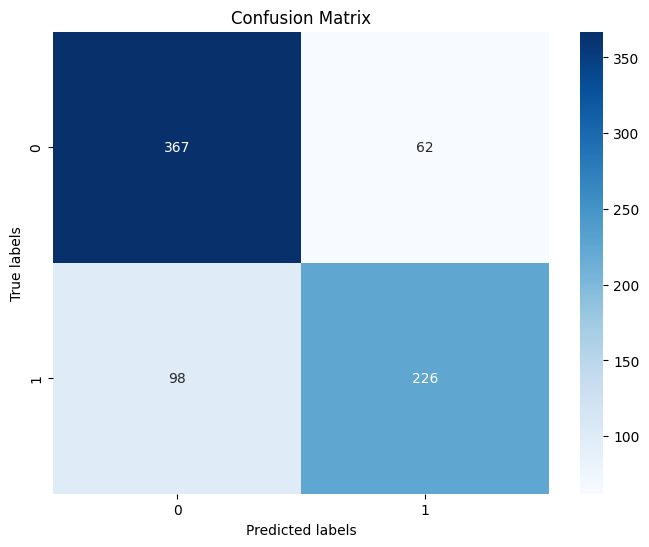

In [68]:
display_confusion_matrix(ytest, y_pred_classes_4)
plot_confusion_matrix(ytest, y_pred_classes_4)

In [54]:
# Assuming y_true contains the true binary labels (0 and 1) and y_pred contains the predicted labels
sensitivity_4, specificity_4 = calculate_sensitivity_specificity(ytest, y_pred_classes_4)

print(f"Sensitivity (True Positive Rate, TPR): {sensitivity_4}")
print(f"Specificity (True Negative Rate, TNR): {specificity_4}")

Sensitivity (True Positive Rate, TPR): 0.6975308641975309
Specificity (True Negative Rate, TNR): 0.8554778554778555


#MODEL 5 (Model 1 features extracted and a random classifier)

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Extract features from the second last fully connected layer
feature_extractor_m1 = tf.keras.Model(inputs=model1.inputs, outputs=model1.layers[-2].output)

# Predict the features for train and test data
train_features_m1 = feature_extractor_m1.predict(Xtrain)
test_features_m1 = feature_extractor_m1.predict(Xtest)

# Model features using Random Forest classifier
rf_classifier_m1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_m1.fit(train_features_m1, ytrain)

# Predict using the Random Forest classifier
predictions_m1 = rf_classifier_m1.predict(test_features_m1)

# Calculate accuracy
accuracy_m1 = accuracy_score(ytest, predictions_m1)
print("Accuracy of Random Forest classifier on extracted features model 1:", accuracy_m1)

24/24 [==============================] - 4s 175ms/step
Accuracy of Random Forest classifier on extracted features model 1: 0.8087649402390438


#MODEL 6 (Model 4 features extracted and a random classifier)

In [56]:
# Extract features from the second last fully connected layer
feature_extractor_m2 = tf.keras.Model(inputs=build_model_4.inputs, outputs=build_model_4.layers[-2].output)

# Predict the features for train and test data
train_features_m2 = feature_extractor_m2.predict(Xtrain)
test_features_m2 = feature_extractor_m2.predict(Xtest)

# Model features using Random Forest classifier
rf_classifier_m2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_m2.fit(train_features_m2, ytrain)

# Predict using the Random Forest classifier
predictions_m2 = rf_classifier_m2.predict(test_features_m2)

# Calculate accuracy
accuracy_m2 = accuracy_score(ytest, predictions_m2)
print("Accuracy of Random Forest classifier on extracted features Model 2:", accuracy_m2)

24/24 [==============================] - 0s 15ms/step
Accuracy of Random Forest classifier on extracted features Model 2: 0.7835325365205843


#Stacking both the model 1 and model 4 features and then using a random classifier

In [57]:
# Extract the deep features from Model-1 and Model-2 and stack the features horizontally
train_stacked_features = np.hstack((train_features_m1, train_features_m2))
test_stacked_features = np.hstack((test_features_m1, test_features_m2))

In [58]:
train_stacked_features.shape,test_stacked_features.shape

((3011, 16), (753, 16))

In [59]:
# Model stacked features using Random Forest classifier
rf_classifier_stack = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_stack.fit(train_stacked_features, ytrain)

# Predict using the Random Forest classifier
predictions_m3 = rf_classifier_stack.predict(test_stacked_features)

# Calculate accuracy
accuracy_m3 = accuracy_score(ytest, predictions_m3)
print("Accuracy of Random Forest classifier on Stacked Features:", accuracy_m3)

Accuracy of Random Forest classifier on Stacked Features: 0.8114209827357237


In [60]:
for n_components in [8, 10, 12]:
    pca = PCA(n_components)
    pca.fit(train_stacked_features)
    features_train_reduced = pca.transform(train_stacked_features)
    features_test_reduced = pca.transform(test_stacked_features)
    rf_classifier_pca = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier_pca.fit(features_train_reduced, ytrain)
    predictions_m4 = rf_classifier_pca.predict(features_test_reduced)
    accuracy_m4 = accuracy_score(ytest, predictions_m4)
    print(f"Accuracy of Random Forest classifier After feature reduction for {n_components} components is :", accuracy_m4)

Accuracy of Random Forest classifier After feature reduction for 8 components is : 0.8193891102257637
Accuracy of Random Forest classifier After feature reduction for 10 components is : 0.8140770252324038
Accuracy of Random Forest classifier After feature reduction for 12 components is : 0.8167330677290837


In [61]:
pca = PCA(8)
pca.fit(train_stacked_features)
features_train_reduced = pca.transform(train_stacked_features)
features_test_reduced = pca.transform(test_stacked_features)
rf_classifier_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_pca.fit(features_train_reduced, ytrain)
predictions_m4 = rf_classifier_pca.predict(features_test_reduced)
accuracy_m4 = accuracy_score(ytest, predictions_m4)
print(f"Accuracy of Random Forest classifier After feature reduction for {n_components} components is :", accuracy_m4)

Accuracy of Random Forest classifier After feature reduction for 12 components is : 0.8193891102257637


In [63]:
accuracy = accuracy_score(ytest, predictions_m4)
precision = precision_score(ytest,predictions_m4, average='weighted')
recall = recall_score(ytest,predictions_m4, average='weighted')
f1 = f1_score(ytest,predictions_m4, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.8193891102257637
Precision: 0.8188964011388599
Recall: 0.8193891102257637
F1-score: 0.8189308262504094


|True \ Predicted|    0     |    1     |
----------------------------------------
|    0     |   367    |    62    |
|    1     |    74    |   250    |
----------------------------------------


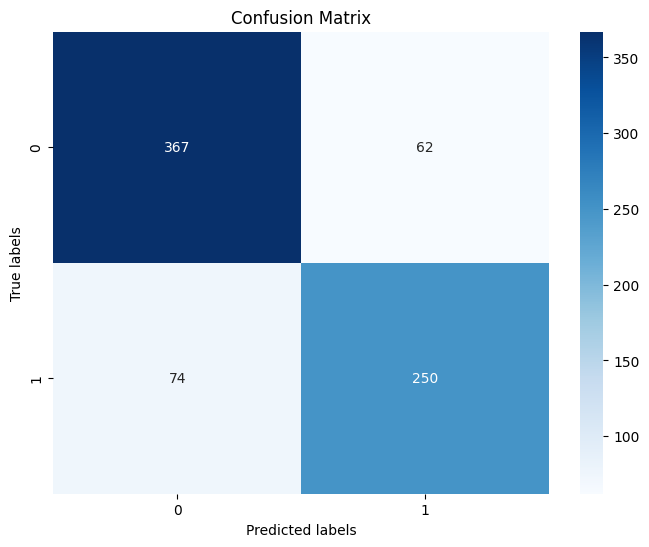

In [69]:
display_confusion_matrix(ytest, predictions_m4)
plot_confusion_matrix(ytest, predictions_m4)

In [65]:
sensitivity_7, specificity_7 = calculate_sensitivity_specificity(ytest, predictions_m4)

print(f"Sensitivity (True Positive Rate, TPR): {sensitivity_7}")
print(f"Specificity (True Negative Rate, TNR): {specificity_7}")

Sensitivity (True Positive Rate, TPR): 0.7716049382716049
Specificity (True Negative Rate, TNR): 0.8554778554778555


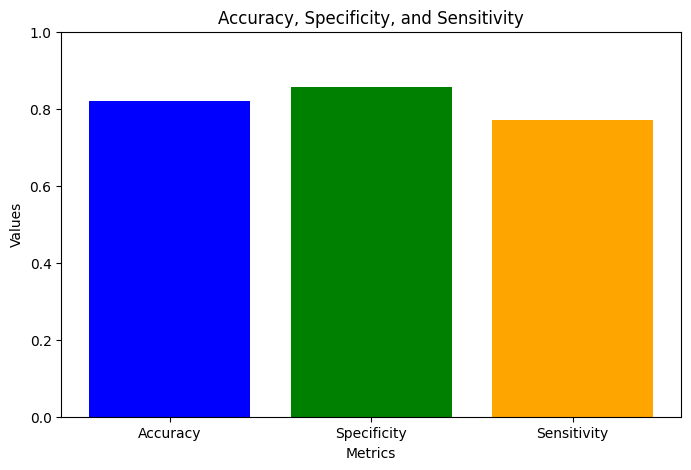

In [72]:
metrics = ['Accuracy', 'Specificity', 'Sensitivity']
values = [accuracy, specificity_7, sensitivity_7]

# Plot the bar graph
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Accuracy, Specificity, and Sensitivity')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for percentage values
plt.show()